In [308]:
import torch
import random
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [426]:
# Read, strip, lowercase
with open("italian_names.txt", "r", encoding="utf-8") as f:
    names = [line.strip().lower() for line in f if line.strip()]

names[:10]

['azzura',
 'maguette',
 'chahde',
 'maili',
 'kejdi',
 'corenzo',
 'gaetanina',
 'neva',
 'elita',
 'erjan']

In [427]:
#Cleaning the dataset
import re

with open("italian_names.txt", "r", encoding="utf-8") as f:
    names = [line.strip().lower() for line in f if line.strip()]

def remove_special_characters(name):
    return re.sub(r'[^a-zA-Z0-9]', '', name)

# Clean and drop names shorter than 2 characters
names = [n for n in (remove_special_characters(name) for name in names) if len(n) >= 3]
names = list(set(names))


In [428]:
len(names)

14642

In [429]:
with open("italian_names.txt", "w", encoding="utf-8") as f:
   for name in names:
      f.write(name + "\n")

In [430]:
#Building the dictionary
characters = sorted(list(set(''.join(names))))

stoi = {ch : index+1 for index, ch in enumerate (characters)}
stoi['!'] = 0 #Start of Sequence
stoi['?'] = len(stoi) #End of Sequence
itos = {index : ch for ch, index in stoi.items()}

In [431]:
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '!',
 27: '?'}

In [432]:
stoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '!': 0,
 '?': 27}

In [433]:
name = "!tommaso?"

# Encode: convert each character to its index
encoded = [stoi[ch] for ch in name]
print("Encoded:", encoded)

# Decode: convert indices back to characters
decoded = ''.join([itos[ix] for ix in encoded])
print("Decoded:", decoded)

Encoded: [0, 20, 15, 13, 13, 1, 19, 15, 27]
Decoded: !tommaso?


In [434]:
#Now I am going to create the dataset
import torch
def create_dataset(names):
   
   X, Y = [],[]
   for name in names:
      context = 0 #! SOS

      for ch in  name + "?":
         ix = stoi[ch]
         X.append(context)
         Y.append(ix)
         #print(itos[context],"-->",itos[ix])
         context = ix
   
   X = torch.tensor(X)
   Y = torch.tensor(Y)

   return X,Y

index1 = int(0.8 * len(names))

Xtr,Ytr = create_dataset(names[:index1])
Xtst, Ytst = create_dataset(names[index1:])

In [435]:
name = ["tommaso"]

x , y  = create_dataset(name)
print("x:", x)
print("y:", y)
for i in range(len(x)):
   print(itos[x[i].item()], "-->", itos[y[i].item()])

x: tensor([ 0, 20, 15, 13, 13,  1, 19, 15])
y: tensor([20, 15, 13, 13,  1, 19, 15, 27])
! --> t
t --> o
o --> m
m --> m
m --> a
a --> s
s --> o
o --> ?


In [436]:
# Bigram counts matrix:V x V where C[i, j] = times char j follows char i.
counts = torch.zeros(len(itos),len(itos))

for i, j in zip(Xtr,Ytr):
   counts[i][j]+=1

counts+=1 #To prevent zero appearence that would broke the proability distribution

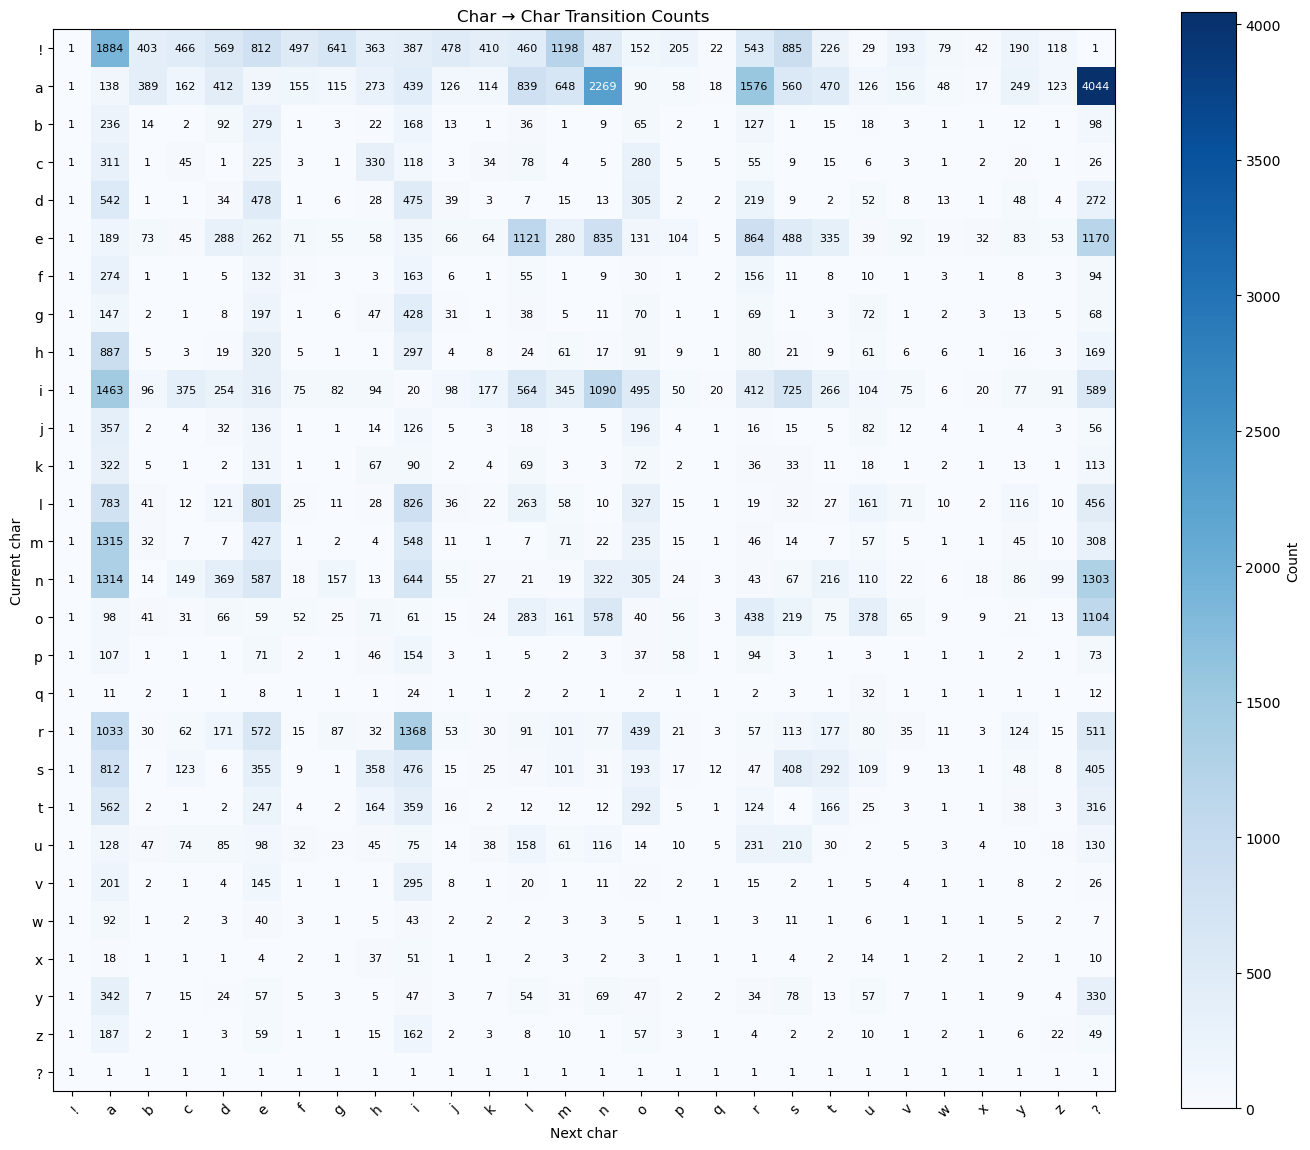

In [437]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(14, 14))  # make the figure large


im = ax.imshow(counts, cmap="Blues", vmin=0, vmax=counts.max())


cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Count")

# set ticks and labels using characters from itos
ax.set_xticks(np.arange(counts.shape[1]))
ax.set_yticks(np.arange(counts.shape[0]))


xlabels = [str(itos[i]) for i in range(counts.shape[1])]
ylabels = [str(itos[i]) for i in range(counts.shape[0])]

ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        val = int(counts[i, j])
        if val > 0:
            ax.text(
                j, i, val,
                ha="center", va="center",
                fontsize=8,
                color="black" if val < counts.max() / 2 else "white"
            )

ax.set_xlabel("Next char")
ax.set_ylabel("Current char")
ax.set_title("Char → Char Transition Counts")

plt.tight_layout()
plt.show()

In [438]:
V = len(itos)
probs = torch.zeros((V, V), dtype=torch.float32)

for i in range(V):
    row_sum = counts[i].sum().item()    # total count for row i
    for j in range(V):
        probs[i, j] = counts[i, j].item() / row_sum


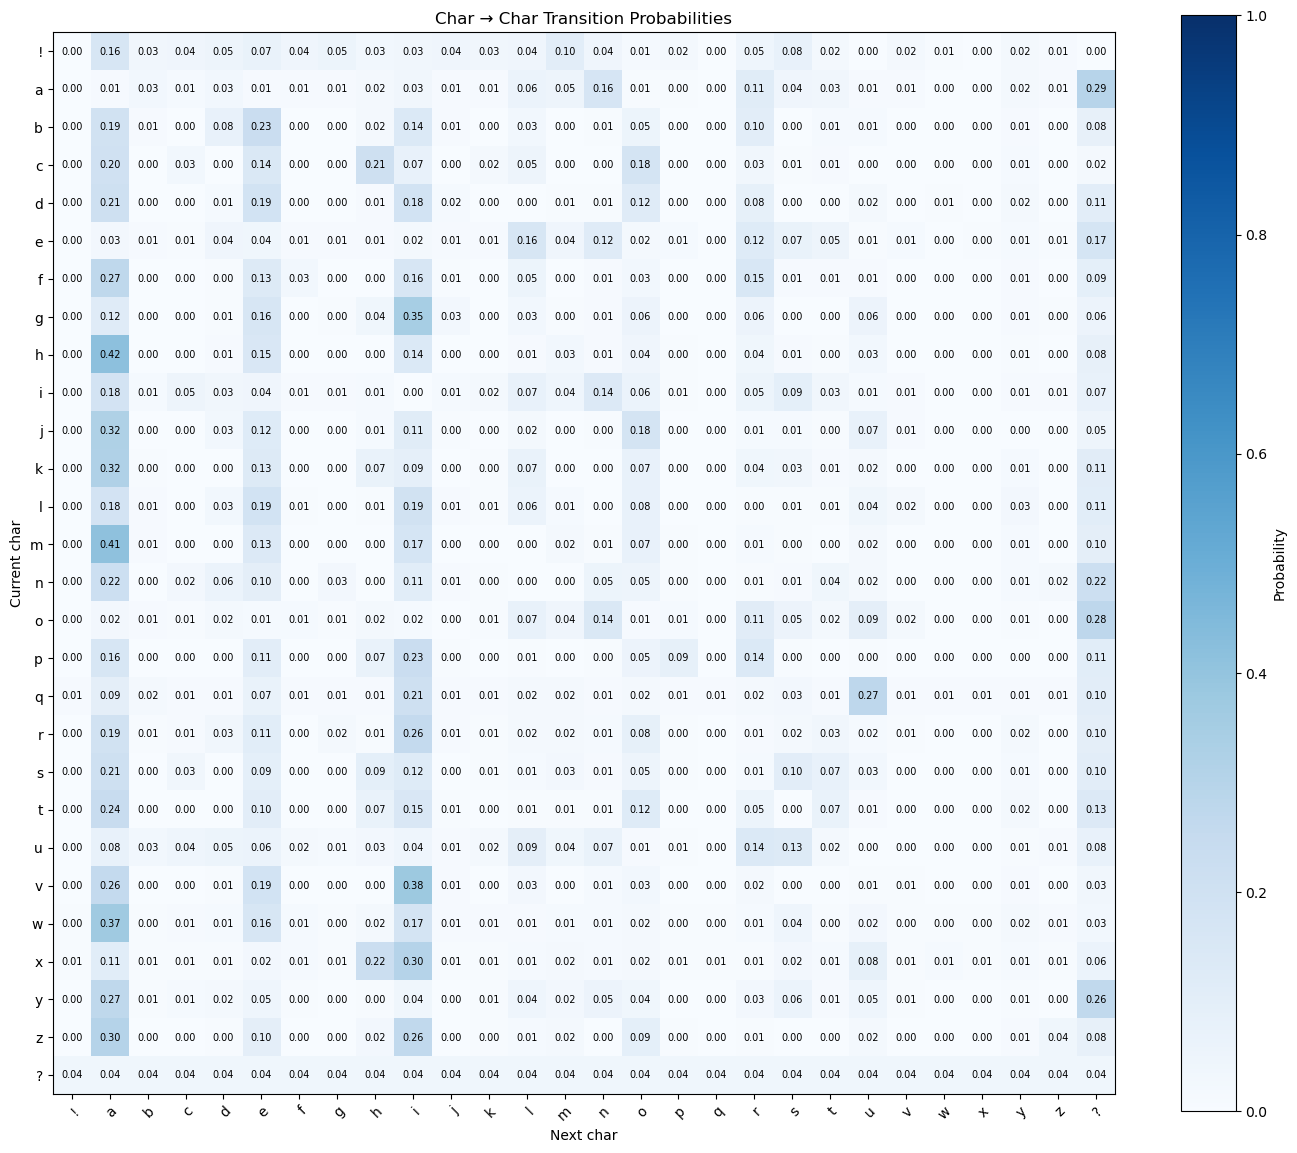

In [439]:
import matplotlib.pyplot as plt
import numpy as np



if not isinstance(counts, np.ndarray):
    counts = counts.cpu().numpy()

fig, ax = plt.subplots(figsize=(14, 14))

# draw the heatmap of probabilities
im = ax.imshow(probs, cmap="Blues", vmin=0, vmax=1)

# add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Probability")


ax.set_xticks(np.arange(probs.shape[1]))
ax.set_yticks(np.arange(probs.shape[0]))
xlabels = [str(itos[i]) for i in range(probs.shape[1])]
ylabels = [str(itos[i]) for i in range(probs.shape[0])]
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

# rotate x tick labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(probs.shape[0]):
    for j in range(probs.shape[1]):
        p = probs[i, j]
        if p > 0:  
            ax.text(
                j, i, f"{p:.2f}",   # show with 2 decimals
                ha="center", va="center",
                fontsize=7,
                color="black" if p < 0.5 else "white"
            )

ax.set_xlabel("Next char")
ax.set_ylabel("Current char")
ax.set_title("Char → Char Transition Probabilities")

plt.tight_layout()
plt.show()

In [440]:
def generate(togenerate, maxlen=15):
   for _ in range(togenerate):
      context = 0
      s = ""
      for _ in range(maxlen):
         prob = probs[context]  # distribuzione del prossimo char
         idx = torch.multinomial(prob, 1).item()
         context = idx
         ch = itos[idx]
         if ch == "?":
            break
         s += ch
      print(s)



In [441]:
generate(10)

palelel
etieraka
meeleliriantagi
c
rithare
aylaxienneablia
bdrinanitie
sahazeneredord
ka
naro


In [442]:
# Evaluate bigram model loss on Xtst
with torch.no_grad():
   # Get the probabilities for each (current char, next char) in Xtst/Ytst
   log_probs = torch.log(probs[Xtst, Ytst])
   loss_bigram = -log_probs.mean().item()
print("Bigram model loss on test set:", loss_bigram)

Bigram model loss on test set: 2.4792838096618652


In [443]:
## NN approach we are going to use three character to predict the next one, we need to create the dataset
#Now I am going to create the dataset
import torch
block_size = 3
def create_dataset(names):
  
   X, Y = [],[]
   for name in names:
      context = [0]*block_size #! SOS

      for ch in  name + "?":
         ix = stoi[ch]
         X.append(context)
         Y.append(ix)
         #print(itos[context],"-->",itos[ix])
         context = context[1:] + [ix]
   
   X = torch.tensor(X)
   Y = torch.tensor(Y)

   return X,Y

index1 = int(0.8 * len(names))

Xtr,Ytr = create_dataset(names[:index1])
Xtst, Ytst = create_dataset(names[index1:])





In [444]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

device: mps


In [509]:
vocab_size = len(itos)
embedding_dim = 32
hidden_dim = 512
batch_size = 256

In [510]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_len=3):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Flattened embeddings of 3 tokens → one vector
        self.fc1 = nn.Linear(context_len * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        """
        x: (batch, context_len) of integer indices
        returns: (batch, vocab_size) logits
        """
        emb = self.embeddings(x)                  # (batch, context_len, embed_dim)
        flat = emb.view(x.size(0), -1)       # (batch, context_len*embed_dim)
        h = torch.relu(self.fc1(flat))              # (batch, vocab_size)
        logits = self.fc2(h)
        return logits

In [511]:
model = Net(vocab_size,embedding_dim).to(device)

In [512]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=2e-4)

In [513]:
Xtr = Xtr.to(device)            # long
Ytr = Ytr.to(device)            # long
Xtst = Xtst.to(device)          # if you have a test set
Ytst = Ytst.to(device)

In [514]:
model.train()
epochs = 3
iters_per_epoch = 10000
lossi = []
N = Xtr.size(0)              
for _ in range(epochs):
   for _ in range(iters_per_epoch):
      
      idx = torch.randint(0, N, (batch_size,),device=device)   # shape (B,)

      X = Xtr[idx]            # (B, 3)  
      y = Ytr[idx]            # (B,)    

      logits = model(X)       # (B, vocab_size)
      loss = F.cross_entropy(logits, y)
      lossi.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

   print(loss.item())



2.0182251930236816
2.035360097885132
1.919320821762085


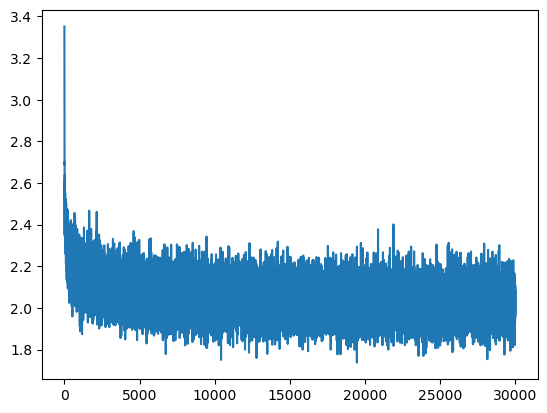

In [451]:
plt.plot(lossi)

In [508]:
@torch.no_grad()
def eval_minibatch():
    idx = torch.randint(0, Xtst.size(0), (4096,), device=device)
    logits = model(Xtst[idx])
    y = Ytst[idx]
    loss = F.cross_entropy(logits, y).item()
    acc = (logits.argmax(1) == y).float().mean().item()
    return loss, acc
eval_minibatch()

(2.1739368438720703, 0.330810546875)

In [453]:

@torch.no_grad()
def generate(n_samples=10, maxlen=15, temperature=1.0, top_k=None):
    model.eval()
    V = len(itos)

    for _ in range(n_samples):
        
        ctx = torch.zeros((1, block_size), dtype=torch.long, device=device)  # [[0,0,...,0]]
        s = []

        for _ in range(maxlen):
            logits = model(ctx)                          # (1, V) logits

            probs = F.softmax(logits, dim=1)            # (1, V)
            next_idx = torch.multinomial(probs, 1)      # (1, 1)
            ix = next_idx.item()                         # python int

            ch = itos[ix]
            if ch == "?":
                break
            s.append(ch)

            # slide window left and drop new token on the right
            ctx = torch.roll(ctx, shifts=-1, dims=1)     # still (1, block_size)
            ctx[0, -1] = ix

        print("".join(s))





In [425]:
generate(10)

eder
giadan
salprinomanpree
nou
yer
abel
serena
jacartina
bessa
emma
